# Results of PINNs for freeze-in Dark Matter

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import utils

import numpy as np
from scipy.integrate import solve_ivp
from scipy.stats import norm

import tensorflow as tf
from tensorflow.keras.layers import Dense, Input

import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter

E0000 00:00:1740406515.811284   10735 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1740406515.814414   10735 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
plt.rcParams.update({
    "savefig.dpi": 200,
    "text.usetex": True,
    "font.family": "serif",
    "font.sans-serif": ["Computer Modern Sans Serif"]})

In [3]:
z0 = utils.Z0
z0_alt = np.log(1e-4) # Only used by solve_ivp when dealing with the Randall-Sundrum cosmology
zf = utils.ZF

w0 = utils.W0
wf = utils.WF

z_n = zf
w_n = - w0

g = utils.G
g_asts = utils.G_ASTS

C_std = utils.C_STD
C_rs = utils.C_RS
C_gb = utils.C_GB

gamma_std = utils.GAMMA_STD
gamma_rs = utils.GAMMA_RS
gamma_gb = utils.GAMMA_GB

zt1 = utils.ZT1
zt2 = utils.ZT2

In [4]:
def w_eq_fem(z):
    """
    Computes W_eq for the finite element method.

    Parameters:
        z (float): The logarithm of x = m_DM / T.
        
    Returns:
        float: The definition of W_eq.
    """
    
    return np.log(45 / np.sqrt(32 * np.pi**7) * g / g_asts) + 3/2 * z - np.exp(z)

## Forward problem: parametric PINN solution

### Evolution of the loss

In [5]:
def LossPlotFwd(input_file, color, cosmology, output_file):
    """ 
    Plots the evolution of the loss in forward problems.

    Parameters:
    input_file (string): Directory of the file with the loss for each epoch.
    color (string): Color of the line of the plot.
    cosmology (string): Cosmology (Standard, RS or GB).
    output_file (string): Directory to save the plot.
    """ 
    
    loss = np.loadtxt(input_file)
    epochs = np.arange(0, loss.shape[0], 1, dtype='int32')

    plt.figure(figsize = (10, 8))
    plt.plot(epochs/1e5, loss, color)

    plt.xlabel(r"Epoch $\times 10^5$", fontsize=24)
    plt.ylabel(r"$\log_{10}\mathcal{L}_{\rm Fwd}$", fontsize=24)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.title(cosmology +  ' Cosmology', fontsize=26)

    plt.savefig(output_file, bbox_inches='tight', pad_inches=0.01)
    plt.show()

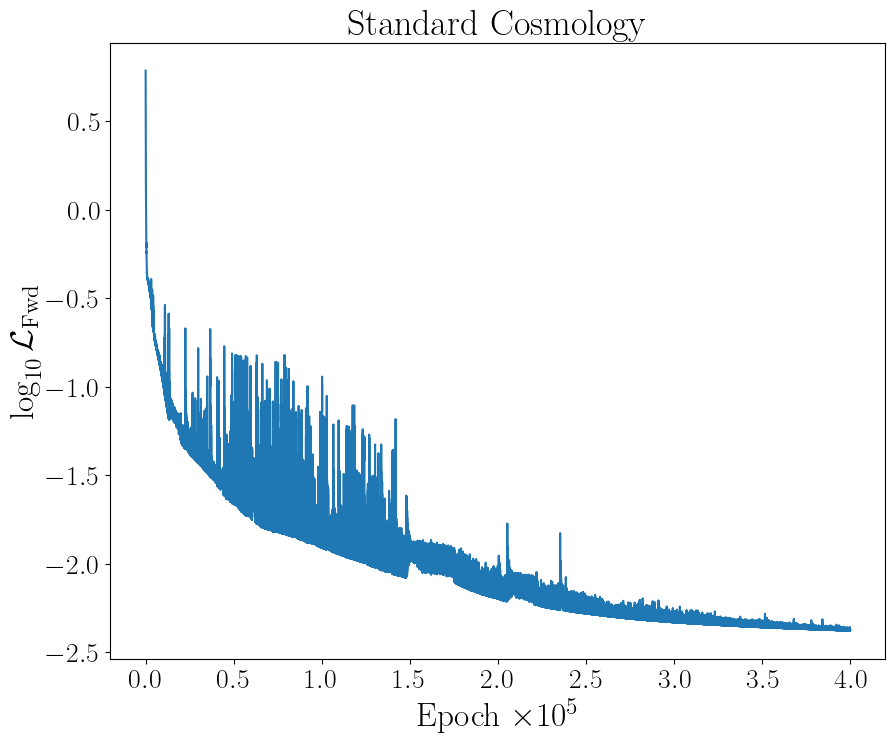

In [6]:
LossPlotFwd('data/LossFwdStd.txt', 'C0', 'Standard', 'LossFwdStd.png')

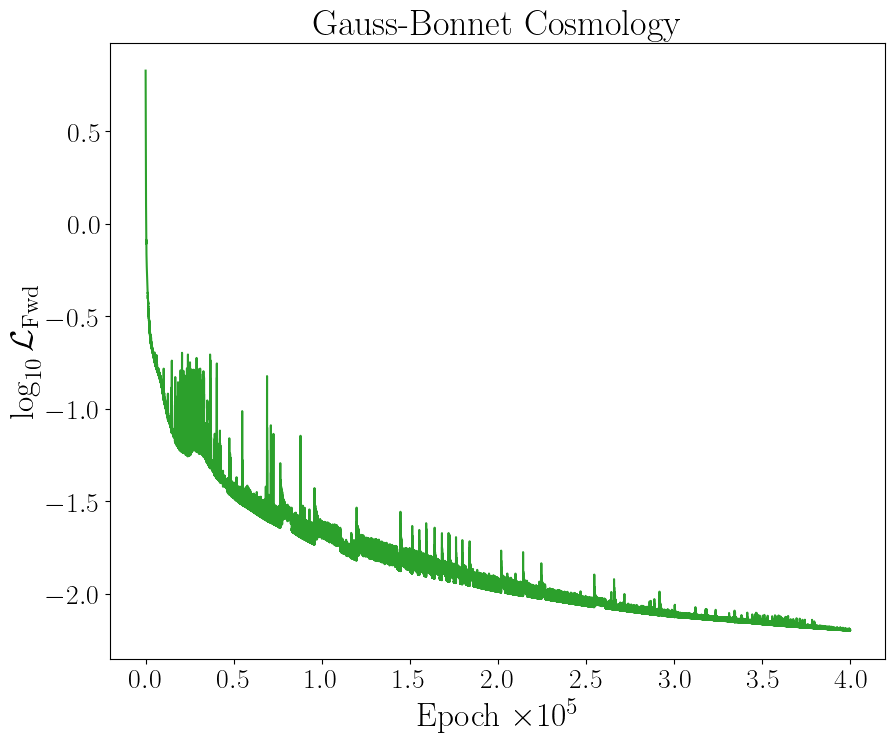

In [7]:
LossPlotFwd('data/LossFwdGB.txt', 'C2', 'Gauss-Bonnet', 'LossFwdGB.png')

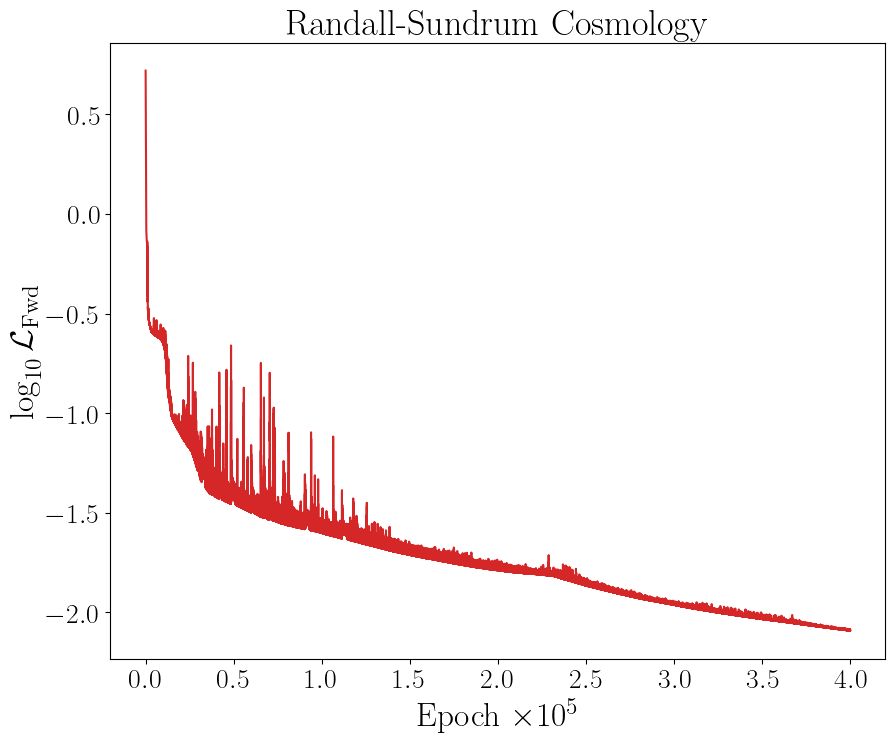

In [8]:
LossPlotFwd('data/LossFwdRS.txt', 'C3', 'Randall-Sundrum', 'LossFwdRS.png')

### Yield as a function of $z$ and $C$

In [9]:
def returns_dwdz_std(z, w, C): 
    """
    Computes the derivative of the Boltzmann equation in Standard cosmology, for comparison purposes.

    Parameters:
        z (float): The logarithm of x = m_DM / T.
        w (float): The logarithm of Y, the number density of DM.
        C (float): Proxy for the cross-section.
        
    Returns:
        float: The derivative of the Boltzmann equation.
    """
    
    return np.exp(C - z + 2 * w_eq_fem(z) - w)

  
# initial condition 
y0 = np.array([np.log(10**(-25))])
  
# values of time 
t_Std = np.linspace(np.log(1e-8), np.log(100), 200) 
t_GB = np.linspace(np.log(1e-13), np.log(100), 200) 
t_RS = np.linspace(np.log(1e-4), np.log(100), 200) 
  
# solving ODE 
sol_lower_Std = solve_ivp(returns_dwdz_std, [np.log(1e-8), np.log(100)], y0, method='BDF', args=[-14], t_eval=t_Std, dense_output=True, rtol=1e-7, atol=1e-9) 
sol_lower_GB = solve_ivp(returns_dwdz_std, [np.log(1e-13), np.log(100)], y0, method='BDF', args=[-14], t_eval=t_GB, dense_output=True, rtol=1e-7, atol=1e-9) 
sol_lower_RS = solve_ivp(returns_dwdz_std, [np.log(1e-4), np.log(100)], y0, method='BDF', args=[-14], t_eval=t_RS, dense_output=True, rtol=1e-7, atol=1e-9) 

sol_upper_Std = solve_ivp(returns_dwdz_std, [np.log(1e-8), np.log(100)], y0, method='BDF', args=[-9], t_eval=t_Std, dense_output=True, rtol=1e-7, atol=1e-9) 
sol_upper_GB = solve_ivp(returns_dwdz_std, [np.log(1e-13), np.log(100)], y0, method='BDF', args=[-9], t_eval=t_GB, dense_output=True, rtol=1e-7, atol=1e-9) 
sol_upper_RS = solve_ivp(returns_dwdz_std, [np.log(1e-4), np.log(100)], y0, method='BDF', args=[-9], t_eval=t_RS, dense_output=True, rtol=1e-7, atol=1e-9) 

In [10]:
def negative_sigm(x):
    """
    Computes the negative sigmoid.

    Parameters:
        x: Input.
        
    Returns:
        Negative sigmoid.
    """
    
    return - tf.nn.sigmoid(x)

In [11]:
def nn(units, num_layers=4, kernel_init='glorot_uniform'):
    """
    Builds a feedforward neural network model using the Keras functional API.

    The network consists of an input layer followed by a series of Dense layers,
    each using the GELU activation,and a final Dense layer that applies a custom 
    negative sigmoid activation.

    Parameters:
        units (int): Number of units (neurons) in each hidden Dense layer.
        num_layers (int, optional): Total number of Dense layers (including the first one). 
            Default is 4.
        kernel_init (str or tf.keras.initializers.Initializer, optional): Kernel initializer for all Dense layers.
            Default is 'glorot_uniform'.

    Returns:
        tf.keras.Model: A Keras Model instance representing the constructed neural network.
    """
    
    inputs = Input(shape=(2,))
    
    x = Dense(units, activation='gelu', kernel_initializer=kernel_init)(inputs)
    
    for _ in range(num_layers - 1):
        x = Dense(units, activation='gelu', kernel_initializer=kernel_init)(x)

    output = Dense(1, activation=negative_sigm, kernel_initializer=kernel_init)(x)

    
    model = tf.keras.Model(inputs, output)
    
    return model

In [12]:
modelStd = nn(30)
modelGB = nn(30)
modelRS = nn(30)

C_test = np.random.uniform(-14, -9, size=(500, 1))

I0000 00:00:1740406518.410806   10735 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9673 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4070, pci bus id: 0000:01:00.0, compute capability: 8.9


In [13]:
def ParamPlot(model, weight_file, z0, sol_upper, sol_lower, x_text, y_text, cosmology, output_file):
    """
    Plots the PINN result in a mesh-grid of the plane (z, W_n).

    Parameters:
        model: The PINN built using the Keras functional API.
        weight_file (string): Directory where the weights of the PINN are saved.
        z0 (float): Initial value on the horizontal axis (z).
        sol_upper: The yield as a function of z provided by solve_ivp for C=-9.
        sol_lower: The yield as a function of z provided by solve_ivp for C=-14.
        x_text: x-Coordinate for text. 
        y_text: y-Coordinate for text. 
        cosmology: Cosmology (Standard, RS or GB).
        output_file: Directory to save plot.
    """
    
    model.load_weights(weight_file)

    z_test = np.linspace(z0 / np.log(100), 1.0, C_test.shape[0]).reshape(-1, 1)
    ZZ, CC = np.meshgrid(z_test, C_test)
    inptss = np.stack([ZZ.ravel(), CC.ravel()], axis=1)

    f_values = model.predict(inptss)
    f_grid = f_values.reshape(CC.shape)

    plt.figure(figsize = (10,8))

    plt.contourf(ZZ, f_grid, CC, levels=200, cmap='viridis')
    plt.plot(sol_upper.t/np.log(100), sol_upper.y[0] / -np.log(1e-25), '--r')
    plt.plot(sol_lower.t/np.log(100), sol_lower.y[0] / -np.log(1e-25), '--r')
    plt.axhline(y=wf/w_n, color='black', linestyle=':')
    plt.text(x_text, y_text, r'$\Omega h^2=0.12$', rotation=360, fontsize=24)
    plt.xlabel(r"$z$", fontsize=24)
    plt.ylabel(r"$W_n$", fontsize=24)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.title(cosmology +  ' Cosmology', fontsize=26)
    cbar = plt.colorbar(ticks=[-9, -10, -11, -12, -13, -14])
    cbar.ax.tick_params(labelsize=20)
    cbar.set_label(r'$C$', fontsize=24)
    plt.savefig(output_file, bbox_inches='tight', pad_inches=0.01)
    plt.show()

 145/7813 ━━━━━━━━━━━━━━━━━━━━ 2s 349us/step   

I0000 00:00:1740406518.923384   10807 service.cc:148] XLA service 0x71fbb80048d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1740406518.923399   10807 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 4070, Compute Capability 8.9
I0000 00:00:1740406518.936389   10807 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1740406519.002948   10807 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


7813/7813 ━━━━━━━━━━━━━━━━━━━━ 3s 371us/step


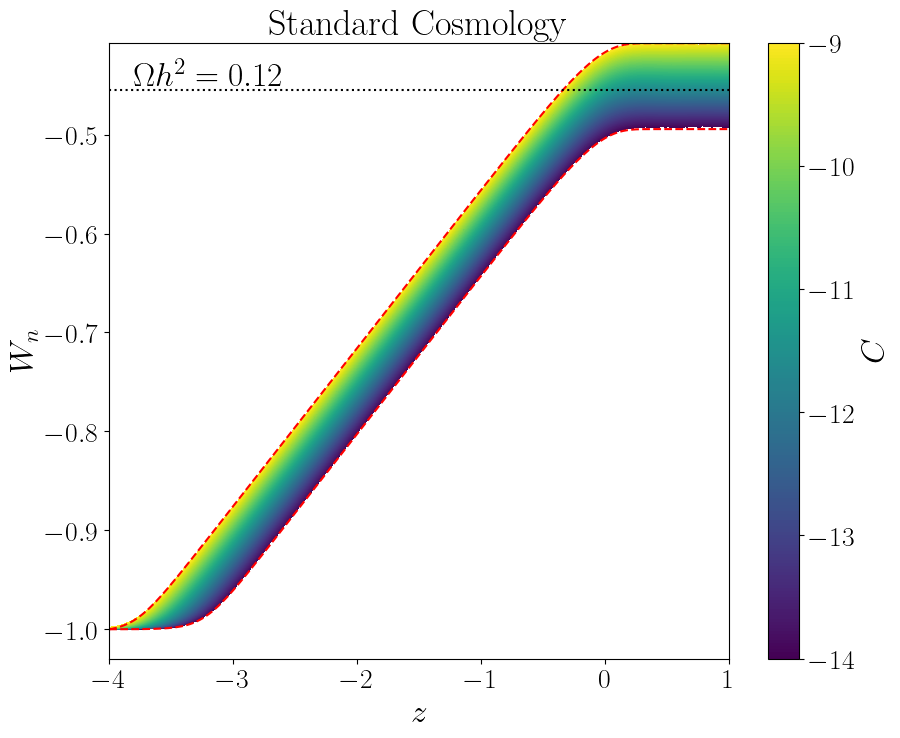

In [14]:
ParamPlot(modelStd, 'data/freeze-in-fwd-parametric-Std.weights.h5', np.log(1e-8), sol_upper_Std, sol_lower_Std, -3.8, -0.45, 'Standard', 'ParametricStd.png')

7813/7813 ━━━━━━━━━━━━━━━━━━━━ 3s 360us/step


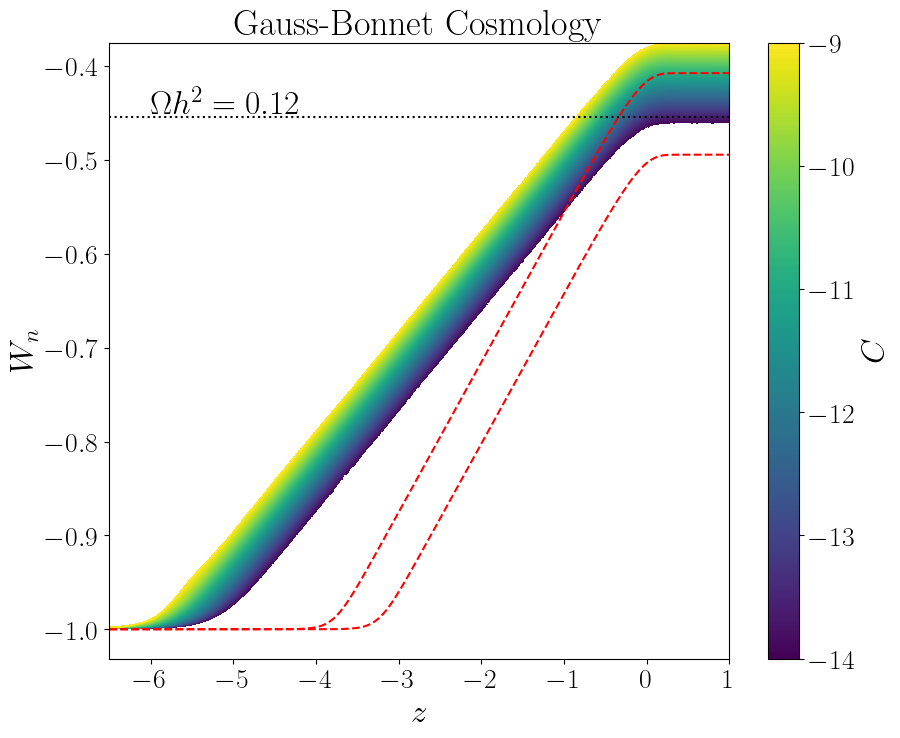

In [15]:
ParamPlot(modelGB, 'data/freeze-in-fwd-parametric-GB.weights.h5', np.log(1e-13), sol_upper_GB, sol_lower_GB, -6.0, -0.45, 'Gauss-Bonnet', 'ParametricGB.png')

7813/7813 ━━━━━━━━━━━━━━━━━━━━ 3s 365us/step


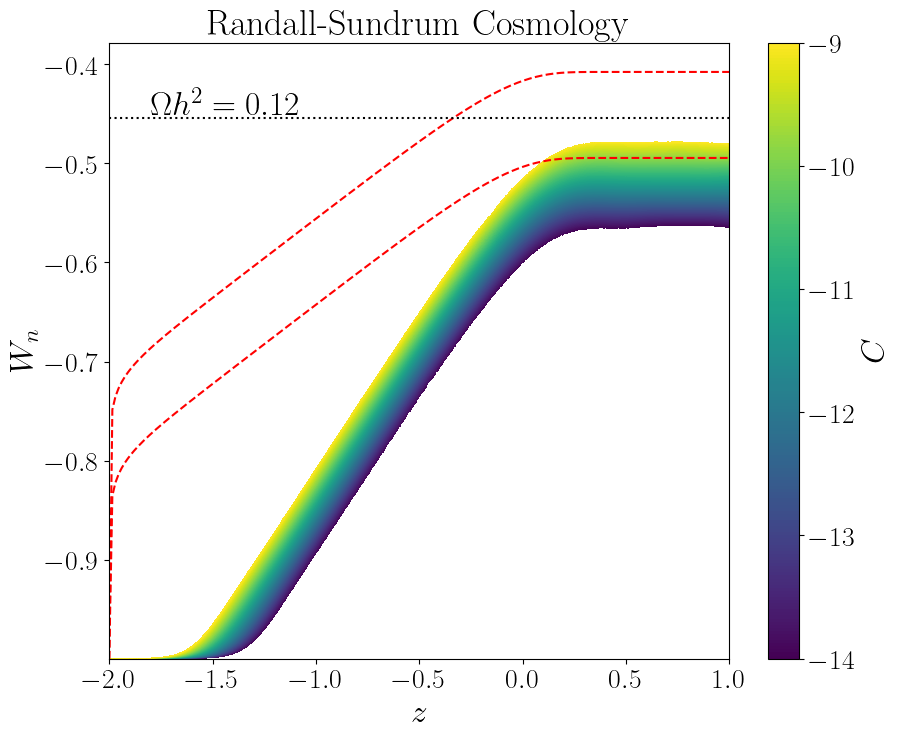

In [16]:
ParamPlot(modelRS, 'data/freeze-in-fwd-parametric-RS.weights.h5', np.log(1e-4), sol_upper_RS, sol_lower_RS, -1.8, -0.45, 'Randall-Sundrum', 'ParametricRS.png')

### Current yield as a function of $C$ (linear plot)

In [17]:
z_test = np.ones((500, 1), dtype=np.float32)
z_test = np.concatenate([z_test, C_test], 1)

yStd = modelStd(z_test)
yGB = modelGB(z_test)
yRS = modelRS(z_test)

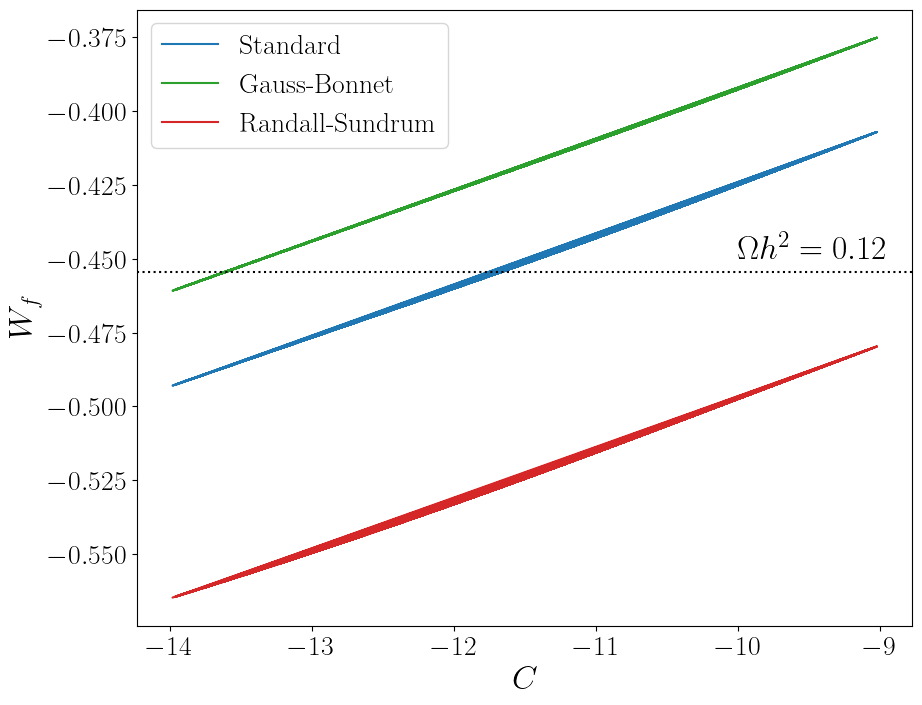

In [18]:
plt.figure(figsize = (10,8))

plt.plot(C_test, yStd, color='C0', label = 'Standard')
plt.plot(C_test, yGB, color='C2', label = 'Gauss-Bonnet')
plt.plot(C_test, yRS, color='C3', label = 'Randall-Sundrum')
plt.axhline(y=wf/w_n, color='black', linestyle=':')
plt.text(-10,-0.45,r'$\Omega h^2=0.12$',rotation=360, fontsize=24)
plt.xlabel(r"$C$", fontsize=24)
plt.ylabel(r"$W_f$", fontsize=24)
plt.xticks([-9, -10, -11, -12, -13, -14], fontsize=20)
plt.yticks(fontsize=20)
plt.legend(fontsize=20)
plt.savefig('Linear.png', bbox_inches='tight', pad_inches=0.01)
plt.show()

## Solving inverse problems with PINNs

## Discovering particle interaction cross sections

### Evolution of the loss

In [19]:
def LossPlotInv(input_file, color, cosmology, output_file):
    """ 
    Plots the evolution of the loss in inverse problems.

    Parameters:
    input_file (string): Directory of the file with the loss for each epoch.
    color (string): Color of the line of the plot.
    cosmology (string): Cosmology (Standard, RS or GB).
    output_file (string): Directory to save the plot.
    """ 
    
    loss = np.loadtxt(input_file)
    epochs = np.arange(0, loss.shape[0], 1, dtype='int32')

    plt.figure(figsize = (10, 8))
    plt.plot(epochs/1e5, loss, color)

    plt.xlabel(r"Epoch $\times 10^5$", fontsize=24)
    plt.ylabel(r"$\log_{10}\mathcal{L}_{\rm Inv}$", fontsize=24)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.title(cosmology +  ' Cosmology', fontsize=26)

    plt.savefig(output_file, bbox_inches='tight', pad_inches=0.01)
    plt.show()

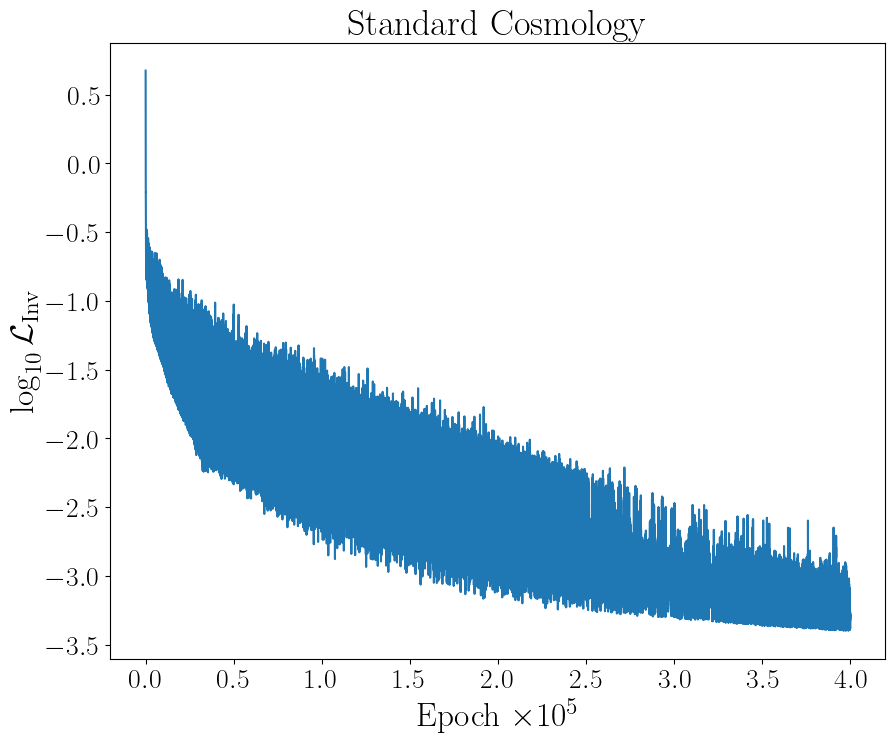

In [20]:
LossPlotInv('data/LossInvStd.txt', 'C0', 'Standard', 'LossInvStd.png')

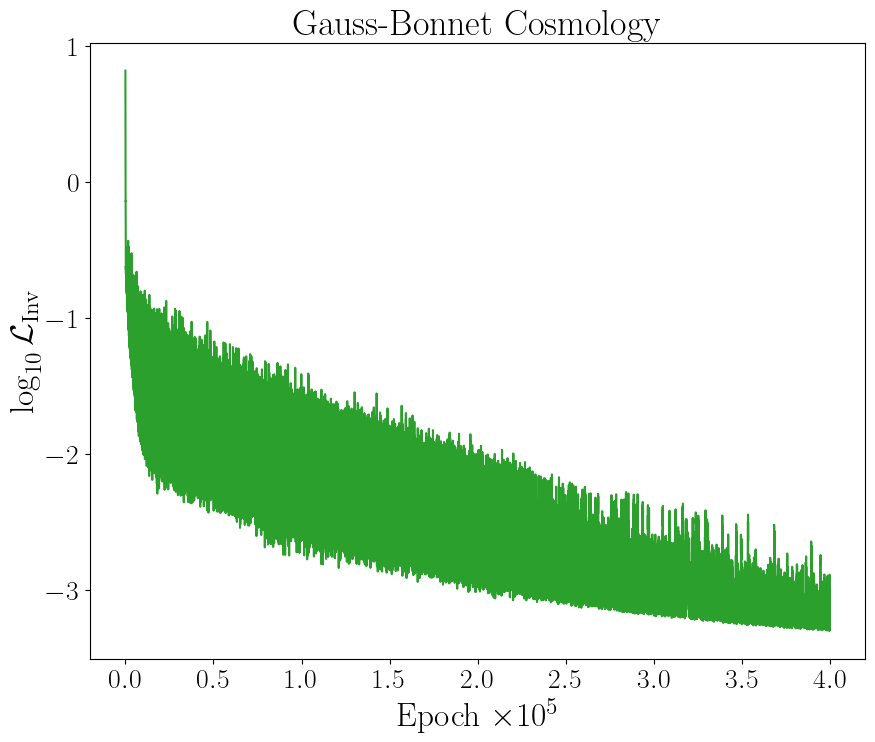

In [21]:
LossPlotInv('data/LossInvGB.txt', 'C2', 'Gauss-Bonnet', 'LossInvGB.png')

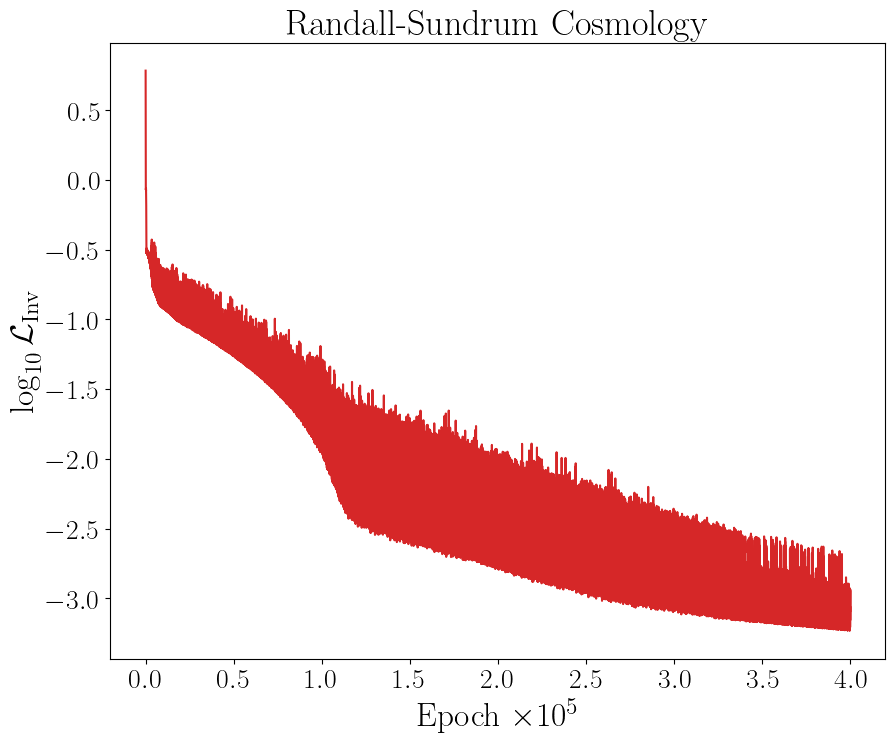

In [22]:
LossPlotInv('data/LossInvRS.txt', 'C3', 'Randall-Sundrum', 'LossInvRS.png')

### Value of C in loss minima

In [23]:
Loss_Std_history = np.loadtxt('data/LossInvStd.txt')
Loss_GB_history = np.loadtxt('data/LossInvGB.txt')
Loss_RS_history = np.loadtxt('data/LossInvRS.txt')

C_Std_history = np.loadtxt('data/CInvStd.txt')
C_GB_history = np.loadtxt('data/CInvGB.txt')
C_RS_history = np.loadtxt('data/CInvRS.txt')

print("Best C in Standard Cosmology: " + str(C_Std_history[np.argmin(Loss_Std_history)]))
print("Best C in GB Cosmology: " + str(C_GB_history[np.argmin(Loss_GB_history)]))
print("Best C in RS Cosmology: " + str(C_RS_history[np.argmin(Loss_RS_history)]))

Best C in Standard Cosmology: -11.696310997009277
Best C in GB Cosmology: -13.580551147460938
Best C in RS Cosmology: -7.496087074279785


### Evolution of C

In [24]:
def CPlot(input_file, color, cosmology, true_C, ymin, ymax, output_file):
    """ 
    Plots the evolution of the C in inverse problems.

    Parameters:
    input_file (string): Directory of the file with the loss for each epoch.
    color (string): Color of the line of the plot.
    cosmology (string): Cosmology (Standard, RS or GB).
    true_C (float): Value of C determined in utils.py for the cosmology being studied.
    ymin (float): Minimum value of C in vertical axis.
    ymax (float): Maximum value of C in vertical axis.
    output_file (string): Directory to save the plot.
    """
    
    c_evol = np.loadtxt(input_file)
    epochs = np.arange(0, c_evol.shape[0], 1, dtype='int32')
    
    plt.figure(figsize=(10, 8))
    plt.plot(epochs/1e5, c_evol, color=color, label='Prediction')
    plt.axhline(y=true_C, color='black', linestyle='--', alpha=0.7, label=rf'$C={{{true_C}}}$')
    plt.xlabel(r"Epoch $\times 10^5$", fontsize=24)
    plt.ylabel(r"$C$", fontsize=24)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.ylim(ymin, ymax)
    plt.legend(fontsize=20)
    plt.title(cosmology +  ' Cosmology', fontsize=26)
    
    plt.savefig(output_file, bbox_inches='tight', pad_inches=0.01)
    plt.show()

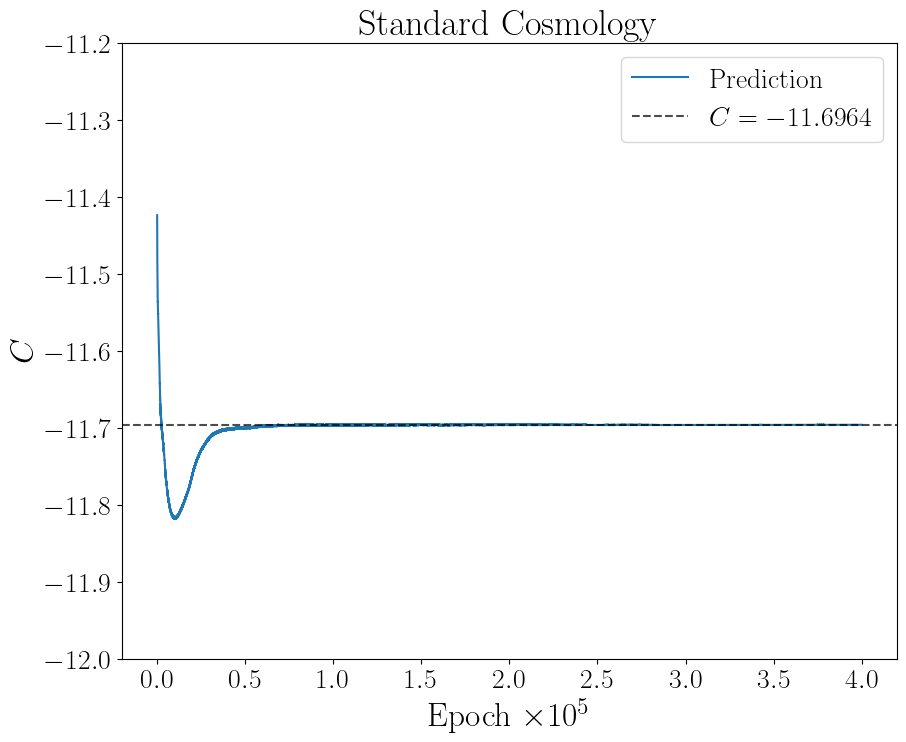

In [25]:
CPlot('data/CInvStd.txt', 'C0', 'Standard', C_std, -12.0, -11.2, 'CInvStd.png')

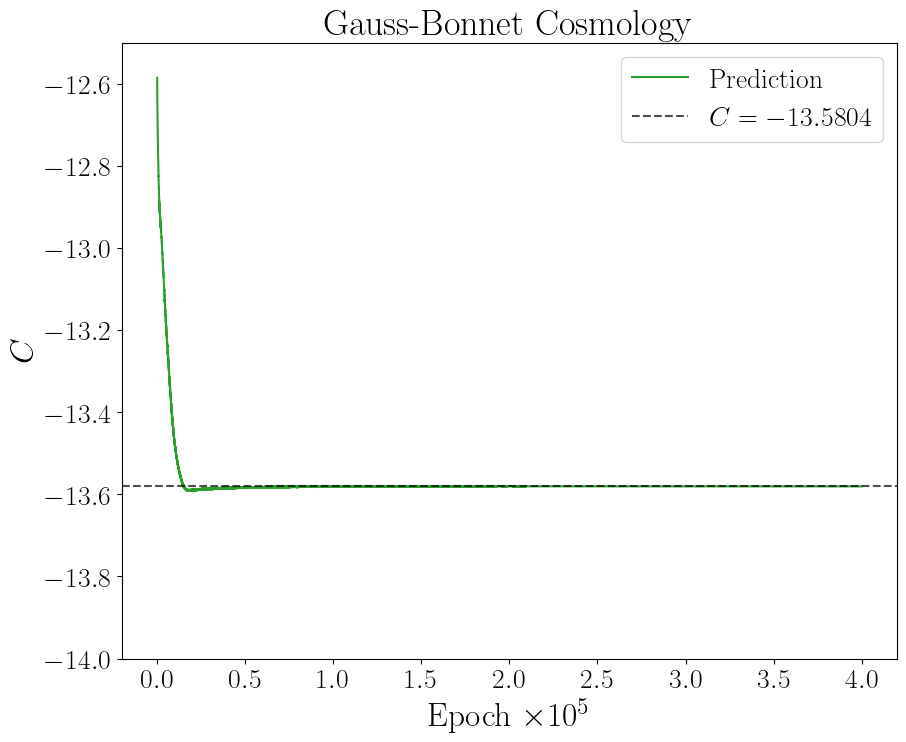

In [26]:
CPlot('data/CInvGB.txt', 'C2', 'Gauss-Bonnet', C_gb, -14, -12.5, 'CInvGB.png')

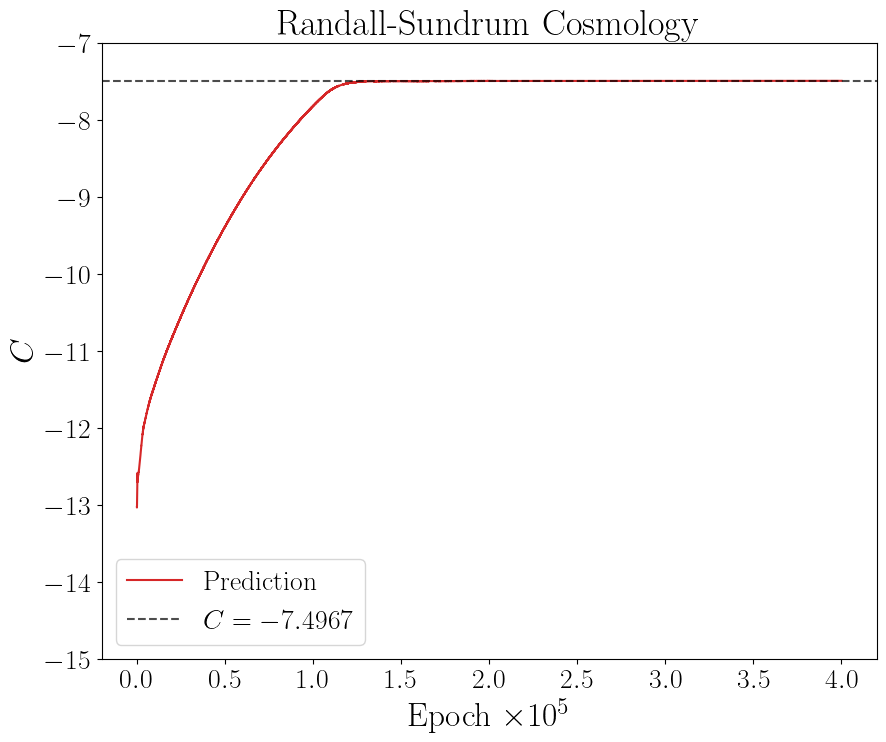

In [27]:
CPlot('data/CInvRS.txt', 'C3', 'Randall-Sundrum', C_rs, -15, -7, 'CInvRS.png')

### Yield as a function of C

In [28]:
# We call this function again, so there is no need to run always the whole notebook.
def negative_sigm(x):
    """
    Computes the negative sigmoid.

    Parameters:
        x: Input.
        
    Returns:
        Negative sigmoid.
    """
    
    return - tf.nn.sigmoid(x)

In [29]:
def nn(units, num_layers=4, kernel_init='glorot_uniform'):
    """
    Builds a feedforward neural network model using the Keras functional API.

    The network consists of an input layer followed by a series of Dense layers,
    each using the GELU activation,and a final Dense layer that applies a custom 
    negative sigmoid activation.

    Parameters:
        units (int): Number of units (neurons) in each hidden Dense layer.
        num_layers (int, optional): Total number of Dense layers (including the first one). 
            Default is 4.
        kernel_init (str or tf.keras.initializers.Initializer, optional): Kernel initializer for all Dense layers.
            Default is 'glorot_uniform'.

    Returns:
        tf.keras.Model: A Keras Model instance representing the constructed neural network.
    """
    
    inputs = Input(shape=(1,))
    
    x = Dense(units, activation='gelu', kernel_initializer=kernel_init)(inputs)
    
    for _ in range(num_layers - 1):
        x = Dense(units, activation='gelu', kernel_initializer=kernel_init)(x)

    output = Dense(1, activation=negative_sigm, kernel_initializer=kernel_init)(x)

    
    model = tf.keras.Model(inputs, output)
    
    return model

In [30]:
model_std = nn(30)
model_gb = nn(30)
model_rs = nn(30)

In [31]:
model_std.load_weights('data/freeze-in-inv-Std.weights.h5')
model_gb.load_weights('data/freeze-in-inv-GB.weights.h5')
model_rs.load_weights('data/freeze-in-inv-RS.weights.h5')

1/7 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step

/tmp/ipykernel_10735/3217375771.py:12: RuntimeWarning: overflow encountered in exp
  return np.log(45 / np.sqrt(32 * np.pi**7) * g / g_asts) + 3/2 * z - np.exp(z)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


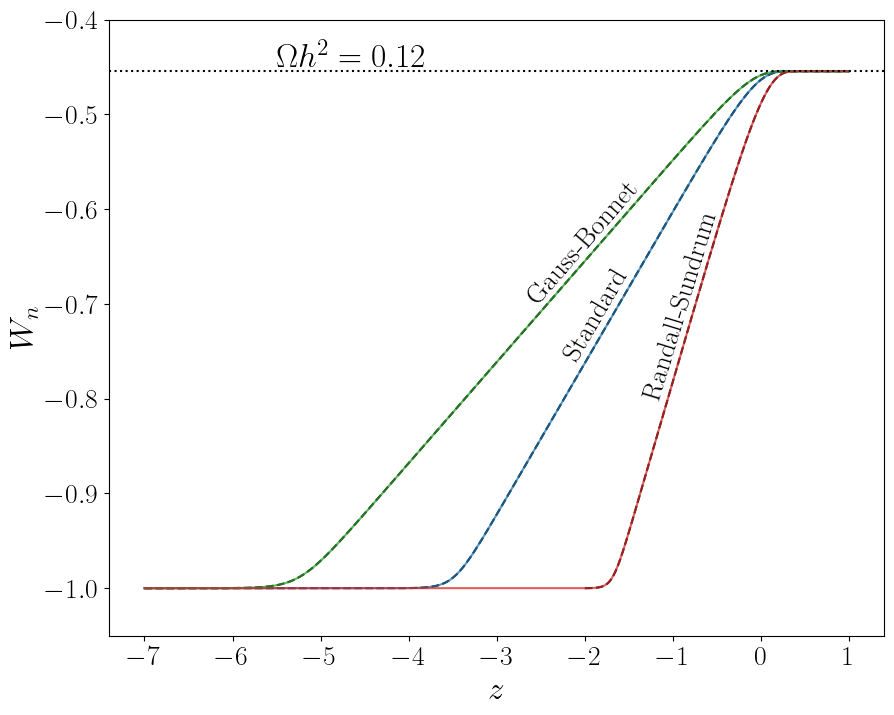

In [32]:
def returns_dwdz(z, w, C, gamma): 
    """
    Computes the derivative of the Boltzmann equation for comparison purposes.

    Parameters:
        z (float): The logarithm of x = m_DM / T.
        w (float): The logarithm of Y, the number density of DM.
        C (float): Proxy for the cross-section.
        gamma (float): Power-law parameter.
        
    Returns:
        float: The derivative of the Boltzmann equation.
    """
    return np.exp(C - z + 2 * w_eq_fem(z) - w - gamma * max(0, zt1 - z))
  
# initial condition 
y0 = np.array([w0])
  
# values of time 
z = np.linspace(z0, zf, 200)
z_alt = np.linspace(z0_alt, zf, 200)
  
# solving ODE 
sol_std = solve_ivp(returns_dwdz, [z0, zf], y0, method='BDF', t_eval=z, args=[C_std, gamma_std], dense_output=True, rtol=1e-7, atol=1e-9) 
sol_gb = solve_ivp(returns_dwdz, [z0, zf], y0, method='BDF', t_eval=z, args=[C_gb, gamma_gb], dense_output=True, rtol=1e-7, atol=1e-9) 
sol_rs = solve_ivp(returns_dwdz, [z0_alt, zf], y0, method='BDF', t_eval=z_alt, args=[C_rs, gamma_rs], dense_output=True, rtol=1e-7, atol=1e-9)

pred_std = model_std.predict(z / zf)
pred_gb = model_gb.predict(z / zf)
pred_rs = model_rs.predict(z / zf)
  
# plot results 
plt.figure(figsize=(10, 8))
plt.plot(sol_std.t/zf, sol_std.y.reshape(-1,)/ -w0, '--', color='black')
plt.plot(sol_gb.t/zf, sol_gb.y.reshape(-1,)/ -w0, '--', color='black')
plt.plot(sol_rs.t/zf, sol_rs.y.reshape(-1,)/ -w0, '--', color='black')
plt.text(-2.7, -0.7, 'Gauss-Bonnet', rotation=49, fontsize=20)
plt.text(-2.28, -0.76, 'Standard', rotation=60, fontsize=20)
plt.text(-1.37, -0.8, 'Randall-Sundrum', rotation=73, fontsize=20)

plt.plot(z / zf, pred_std, color='C0', alpha=0.75)
plt.plot(z / zf, pred_gb, color='C2', alpha=0.75)
plt.plot(z / zf, pred_rs, color='C3', alpha=0.75)
plt.axhline(y=wf/w_n, color='black', linestyle=':')
plt.text(-5.5, -0.45, r'$\Omega h^2=0.12$', rotation=360, fontsize=24)

#plt.ylim(-60, -25)
plt.xlabel(r"$z$", fontsize=24) 
plt.ylabel(r"$W_n$", fontsize=24)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.ylim(-1.05, -0.4)

plt.savefig('InvPreds.png', bbox_inches='tight', pad_inches=0.01)
plt.show()

## Discovering power-law cosmologies

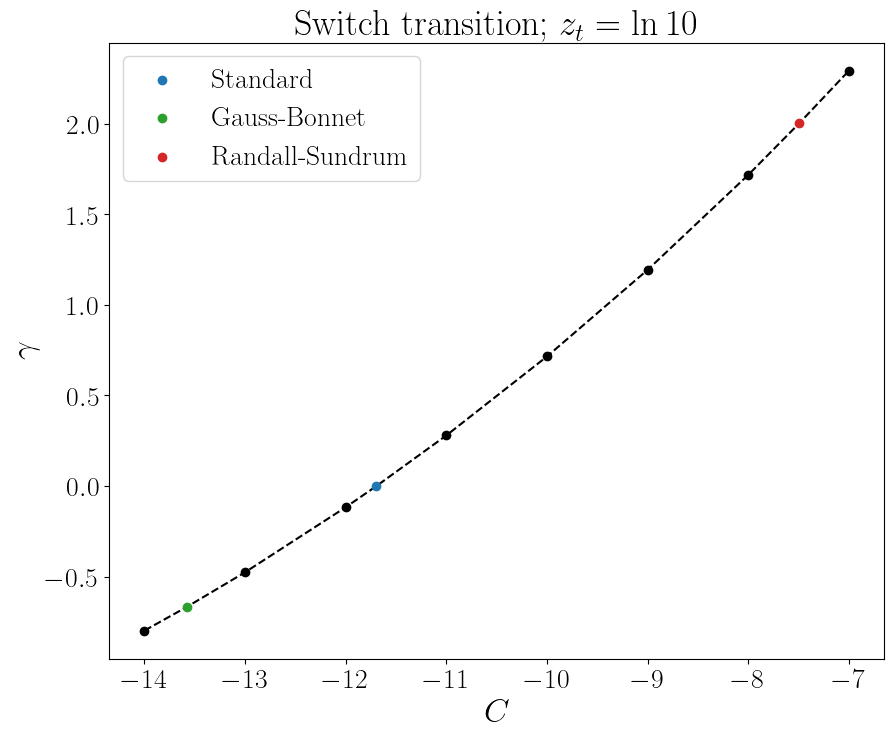

In [33]:
x_all = [-14, C_gb, -13, -12, C_std, -11, -10, -9, -8, C_rs, -7]
y_all = [-0.7969, -0.6667, -0.4750, -0.1162, 0.0001, 0.2800, 0.7156, 1.1936, 1.7174, 2.0005, 2.2922]

x = [-14, -13, -12, -11, -10, -9, -8, -7]
y = [-0.7969, -0.4750, -0.1162, 0.2800, 0.7156, 1.1936, 1.7174, 2.2922]

x_GB = [C_gb]
y_GB = [-0.6667]

x_Std = [C_std]
y_Std = [0.0001]

x_RS = [C_rs]
y_RS = [2.0005]

plt.figure(figsize=(10, 8))

plt.scatter(x_Std, y_Std, color='C0', zorder=1)
plt.scatter(x_GB, y_GB, color='C2', zorder=1)
plt.scatter(x_RS, y_RS, color='C3', zorder=1)
plt.plot(x_all, y_all, color='black', linestyle='dashed', zorder=0)
plt.scatter(x, y, color='black', zorder=1)

plt.legend(['Standard', 'Gauss-Bonnet', 'Randall-Sundrum'], fontsize=20)
plt.xlabel(r"$C$", fontsize=24) 
plt.ylabel(r"$\gamma$", fontsize=24)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.title(r'Switch transition; $z_t=\ln 10$', fontsize=26)

plt.savefig('gammaVsC.png', bbox_inches='tight', pad_inches=0.01)
plt.show()

## Modeling alternative cosmology: transition between power and Hubble law

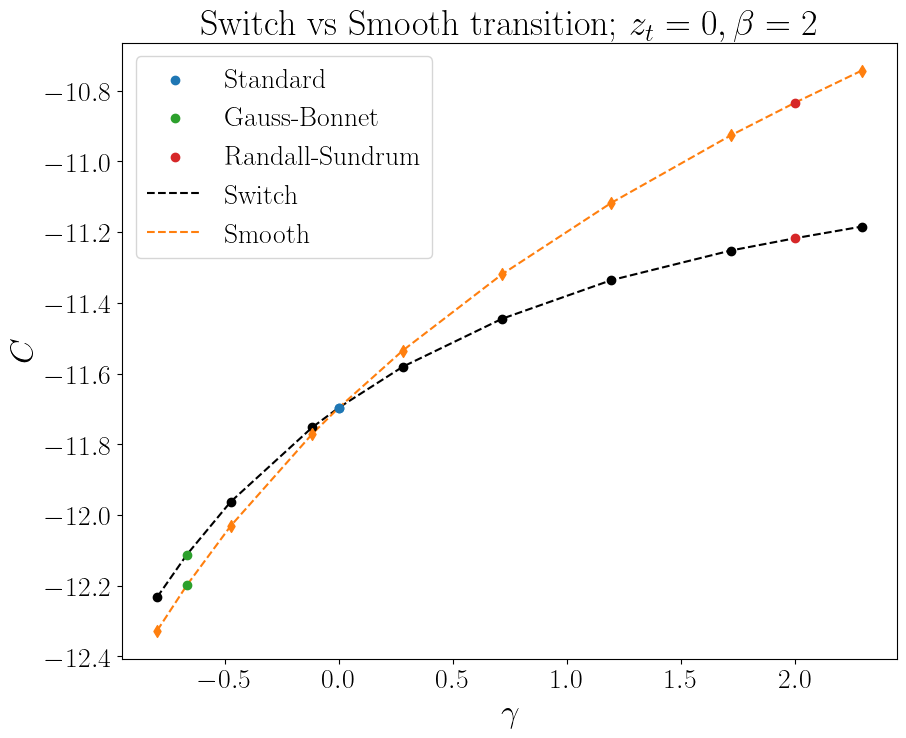

In [34]:
x_all = [-0.7969, gamma_gb, -0.4750, -0.1162, gamma_std, 0.2800, 0.7156, 1.1936, 1.7174, gamma_rs, 2.2922]
yReLU_all = [-12.2327, -12.1125, -11.9632, -11.7519, -11.6964, -11.5808, -11.4450, -11.3360, -11.2521, -11.2172, -11.1843]
ySoft_all = [-12.3274, -12.1990, -12.0317, -11.7704, -11.6965, -11.5350, -11.3190, -11.1174, -10.9265, -10.8337, -10.7429]

x = [-0.7969, -0.4750, -0.1162, 0.2800, 0.7156, 1.1936, 1.7174, 2.2922]
yReLU = [-12.2327, -11.9632, -11.7519, -11.5808, -11.4450, -11.3360, -11.2521, -11.1843]
ySoft = [-12.3274, -12.0317, -11.7704, -11.5350, -11.3190, -11.1174, -10.9265, -10.7429]

x_GB = [gamma_gb]
yReLU_GB = [-12.1125]
ySoft_GB = [-12.1990]

x_Std = [gamma_std]
yReLU_Std = [-11.6964]
ySoft_Std = [-11.6965]

x_RS = [gamma_rs]
yReLU_RS = [-11.2172]
ySoft_RS = [-10.8337]

plt.figure(figsize=(10, 8))

plt.scatter(x_Std, yReLU_Std, color='C0', zorder=1, label='Standard')
plt.scatter(x_Std, ySoft_Std, color='C0', zorder=1)

plt.scatter(x_GB, yReLU_GB, color='C2', zorder=1, label='Gauss-Bonnet')
plt.scatter(x_GB, ySoft_GB, color='C2', zorder=1)

plt.scatter(x_RS, yReLU_RS, color='C3', zorder=1, label='Randall-Sundrum')
plt.scatter(x_RS, ySoft_RS, color='C3', zorder=1)

plt.scatter(x, yReLU, color='black', zorder=1)
plt.scatter(x, ySoft, color='C1', marker='d', zorder=1)

plt.plot(x_all, yReLU_all, color='black', linestyle='dashed', zorder=0, label='Switch')
plt.plot(x_all, ySoft_all, color='C1', linestyle='dashed', zorder=0, label='Smooth')

plt.legend(fontsize=20)
plt.xlabel(r"$\gamma$", fontsize=24) 
plt.ylabel(r"$C$", fontsize=24)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.title(r'Switch vs Smooth transition; $z_t=0, \beta=2$', fontsize=26)

plt.savefig('SwitchVsSmooth.png', bbox_inches='tight', pad_inches=0.01)
plt.show()

## Bayesian PINN: a method to quantify epistemic uncertainties

In [35]:
model = nn(30)

In [36]:
model.load_weights('data/freeze-in-bayesian.weights.h5')

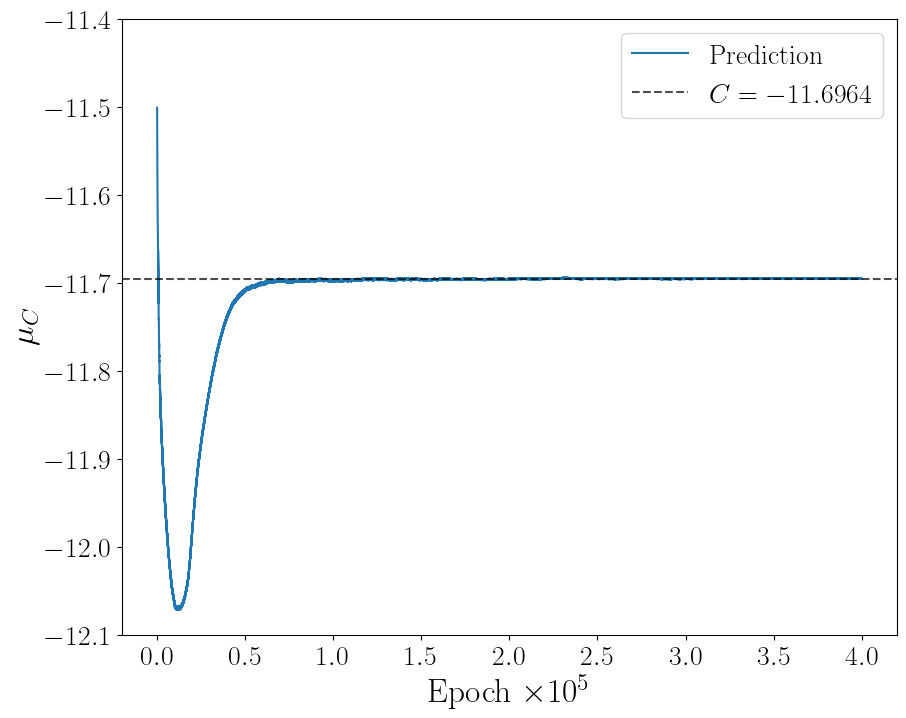

In [37]:
c_evol_mean = np.loadtxt("data/BayesianCmean.txt")
epochs = np.arange(0, c_evol_mean.shape[0], 1, dtype='int32')
    
plt.figure(figsize=(10, 8))
plt.plot(epochs / 1e5, c_evol_mean, color='C0', label='Prediction')
plt.axhline(y=C_std, color='black', linestyle='--', alpha=0.7, label=rf'$C= {{{C_std}}}$')
plt.xlabel(r"Epoch $\times 10^5$", fontsize=24)
plt.ylabel(r"$\mu_C$", fontsize=24)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.ylim(-12.1, -11.4)
plt.legend(fontsize=20)
#plt.title(cosmology +  ' Cosmology', fontsize=26)
    
plt.savefig("BayesianCmean.png", bbox_inches='tight', pad_inches=0.01)
plt.show()

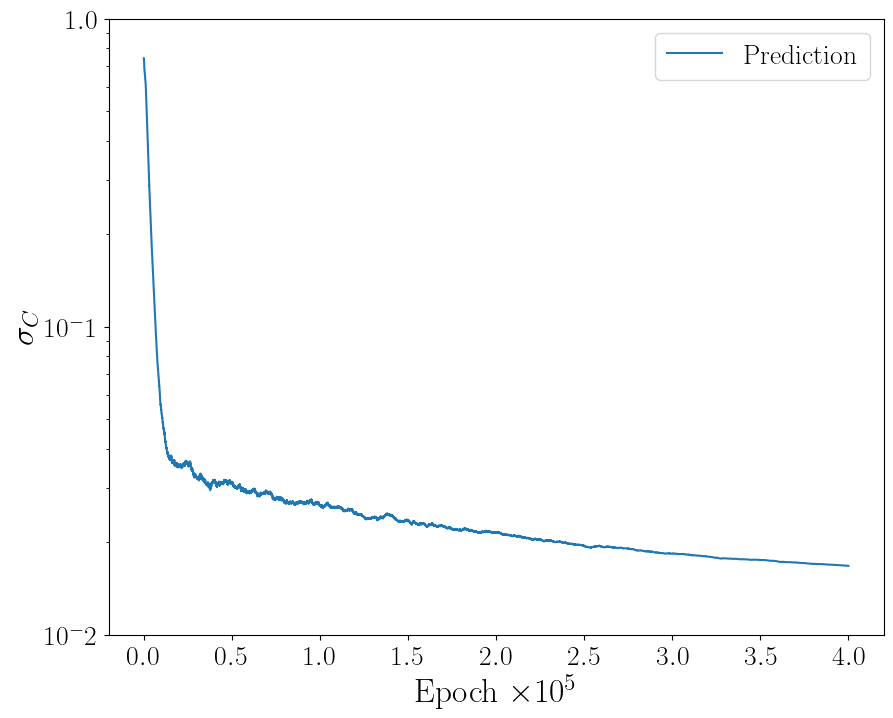

In [38]:
c_evol_std = np.loadtxt("data/BayesianCstd.txt")
epochs = np.arange(0, c_evol_std.shape[0], 1, dtype='int32')
    
plt.figure(figsize=(10, 8))
plt.plot(epochs / 1e5, c_evol_std, color='C0', label='Prediction')
plt.xlabel(r"Epoch $\times 10^5$", fontsize=24)
plt.ylabel(r"$\sigma_C$", fontsize=24)
plt.ylim(0.01,1.0)
plt.yscale('log')
plt.xticks(fontsize=20)
plt.yticks([0.01, 0.1, 1.0], [r'$10^-2$', r'$10^-1$',r'$1.0$'], fontsize=20)
plt.legend(fontsize=20)
    
plt.savefig("BayesianCstd.png", bbox_inches='tight', pad_inches=0.01)
plt.show()

In [39]:
total_loss_history = np.loadtxt("data/BayesianLoss.txt")
Cmean_min = round(c_evol_mean[np.argmin(total_loss_history)], 4)
Cstd_min = round(c_evol_std[np.argmin(total_loss_history)], 4)

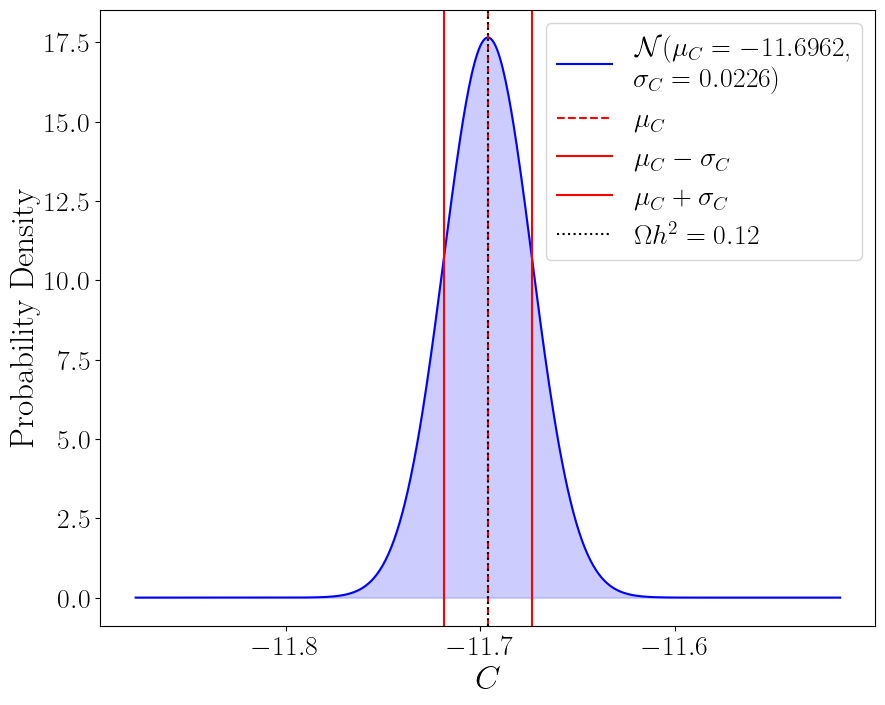

In [40]:
# Parameters for the Gaussian
std_dev = Cstd_min

# Generate c values
c_values = np.linspace(Cmean_min - 8 * std_dev, Cmean_min + 8 * std_dev, 500)

# Generate x values
c_prior = np.linspace(-9.0 - 1 * 2.0, Cmean_min + 1 * 2.0, 500)

# Use scipy to compute the Gaussian PDF
gaussian = norm.pdf(c_values, loc=Cmean_min, scale=std_dev)

c_prior = norm.pdf(c_prior, loc=-9.0, scale=2.0)

# Plot the Gaussian curve
plt.figure(figsize = (10, 8))
plt.plot(c_values, gaussian, label=r'$\mathcal{N}$' + rf'($\mu_C={{{Cmean_min}}}$,' + "\n" + rf'$\sigma_C={{{Cstd_min}}}$)', color='blue')
plt.fill_between(c_values, gaussian, alpha=0.2, color='blue')
#plt.plot(x_prior, y_prior, label='Prior', color='purple')
#plt.fill_between(x_prior, y_prior, alpha=0.2, color='purple')
plt.xlabel(r'$C$', fontsize=24)
plt.ylabel(r'Probability Density', fontsize=24)
#plt.xlim(-12,-11.5)
plt.xticks([-11.8, -11.7, -11.6], fontsize=20)
plt.yticks(fontsize=20)
plt.axvline(Cmean_min, color='red', linestyle='--', label=r'$\mu_C$')
plt.axvline(Cmean_min - std_dev, color='red', linestyle='-', label=r'$\mu_C - \sigma_C$')
plt.axvline(Cmean_min + std_dev, color='red', linestyle='-', label=r'$\mu_C + \sigma_C$')
plt.axvline(C_std, color='black', linestyle='dotted', label=r'$\Omega h^2=0.12$')

plt.legend(fontsize=20)
plt.savefig("Gaussian.png", bbox_inches='tight', pad_inches=0.01)
# Show the plot
plt.show()